# Learning to CIFAR Back!
The CIFAR-10 dataset is a benchmark for computer vision tasks dating to [2009](https://www.cs.toronto.edu/~kriz/cifar.html). We construct a model capable of disentangling an input image created by averaging two random samples from CIFAR-10 and predicting the categories of the two components. We achieve 80% accuracy with an F1 Score of ?. 

This novel task requires training on small datasets (order of 50,000 samples) with small spatial resolution (32x32x3). We overcome this difficulty by eliminating max pooling operations in favor of an All Convolutional Model, inspired by the (second place CIFAR-10 holders)[https://arxiv.org/abs/1412.6806]. The writeup takes the form of a Jupyter notebook, first displaying our most capable model, then chronologically detailing how we arrived to this result.

### 80% Accuracy ACNN3
![ACCN3](ACCN3.png)
### Description
The model has a feature extractor composed purely of two dimensional convolutions. Instead of maxpooling, down sampling the spatial resolution is accomplished by a stride of 2. The extractor reduces the resolution to a stack of 192 2x2 filters. This is flattened and passed to two independent classifiers. They are single layer fully connected layers, with a softmax to produce the 5 possible class probabilities. The network has 20% dropout layers after the stride 2 convolutions to prevent overfitting and no data augmentation, as it did not lead to better results. The standard optimizer has been replaced with [Adagrad](https://keras.io/api/optimizers/adagrad/) which lead to slow but stable convergence. Each classifier has its own cross entropy loss to back propagate through the network, and we observe they do not improve equally, an area for further research on the task.

# Experimental Setup
The reader is invited to train locally by uncommenting the **fit()** calls where indicated.
### Libraries

In [1]:
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.nn import fractional_max_pool
from keras.optimizers import Adam
from tensorflow.keras import backend as K
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.callbacks import Callback
from keras.saving import load_model, save_model, save_weights

### Data Preparation

In [2]:
(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = cifar10.load_data()
assert cifar10_x_train.shape == (50000, 32, 32, 3)
assert cifar10_x_test.shape == (10000, 32, 32, 3)
assert cifar10_y_train.shape == (50000, 1)
assert cifar10_y_test.shape == (10000, 1)

# Split part of the training set into validation set
cifar10_x_train, cifar10_x_val, cifar10_y_train, cifar10_y_val = train_test_split(
    cifar10_x_train, cifar10_y_train, test_size=0.1
)

# First classifier: "airplane", "automobile", "bird", "cat", "deer"
# Second classifier: "dog", "frog", "horse", "ship", "truck"
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Normalizing to range (0,1)
cifar10_x_train = (cifar10_x_train/255.).astype(np.float32)
cifar10_x_val = (cifar10_x_val / 255.).astype(np.float32)
cifar10_x_test = (cifar10_x_test/255.).astype(np.float32)

Split the images in two groups, according to their label.

In [3]:
cond_1 = cifar10_y_train[:,0] < 5
cifar10_x_train_1 = cifar10_x_train[cond_1]
cifar10_y_train_1 = cifar10_y_train[cond_1]

cond_2 = cifar10_y_train[:,0] >= 5
cifar10_x_train_2 = cifar10_x_train[cond_2]
cifar10_y_train_2 = cifar10_y_train[cond_2]

cond_1_val = cifar10_y_val[:,0] < 5
cifar10_x_val_1 = cifar10_x_val[cond_1_val]
cifar10_y_val_1 = cifar10_y_val[cond_1_val]

cond_2_val = cifar10_y_val[:,0] >= 5
cifar10_x_val_2 = cifar10_x_val[cond_2_val]
cifar10_y_val_2 = cifar10_y_val[cond_2_val]

cond_1_test = cifar10_y_test[:,0] < 5
cifar10_x_test_1 = cifar10_x_test[cond_1_test]
cifar10_y_test_1 = cifar10_y_test[cond_1_test]

cond_2_test = cifar10_y_test[:,0] >= 5
cifar10_x_test_2 = cifar10_x_test[cond_2_test]
cifar10_y_test_2 = cifar10_y_test[cond_2_test]

Define the generator. The input consists of two datasets (X1,X2), their corresponding labels (Y1,Y2), and a batch size.

The generator returns (x_data,y_data), where:
* x_data is a batch of images obtained by averaging random samples from X1 and X2.
* y_data is a dictionary of batches of labels corresponding to the component images, expressed in categorical format, in other words, one hot encoded.

In [4]:
batchsize = 64

def datagenerator(X1,X2,Y1,Y2,batchsize):
  size1 = X1.shape[0]
  size2 = X2.shape[0]
  Y1_cat = tf.keras.utils.to_categorical(Y1, num_classes=5)
  Y2_cat = tf.keras.utils.to_categorical(Y2-5, num_classes=5)

  while True:
    num1 = np.random.randint(0, size1, batchsize)
    num2 = np.random.randint(0, size2, batchsize)
    x_data = (X1[num1] + X2[num2]) / 2.0
    y_data = {'output1': Y1_cat[num1], 'output2': Y2_cat[num2]}
    yield tf.convert_to_tensor(x_data), y_data

traingen = datagenerator(cifar10_x_train_1,cifar10_x_train_2,cifar10_y_train_1,cifar10_y_train_2,batchsize)
valgen = datagenerator(cifar10_x_val_1,cifar10_x_val_2,cifar10_y_val_1,cifar10_y_val_2,batchsize)
testgen = datagenerator(cifar10_x_test_1,cifar10_x_test_2,cifar10_y_test_1,cifar10_y_test_2,10000)

We generate an example, display the image that the model will take as input, and print the categories of the two overlapping components.

The reader is invited to re-run the cell to display new examples.

first: cat, second = horse


[]

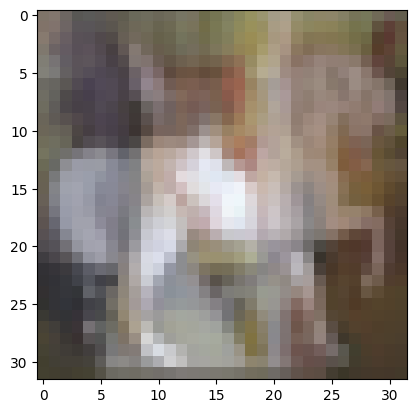

In [5]:
datagen = datagenerator(cifar10_x_train_1,cifar10_x_train_2,cifar10_y_train_1,cifar10_y_train_2,1)
x, y = next(datagen)
print("first: {}, second = {}".format(classes[np.argmax(y['output1'][0])],classes[np.argmax(y['output2'][0])+5]))
plt.imshow(x[0])
plt.plot()

### Model Evaluation
We test our evaluation method with a model which generated random classes.

In [6]:
def random_model():
    inputs = keras.Input(shape=(32,32,3))
    x = layers.Flatten()(inputs)
    output1 = layers.Dense(5, name='output1')(x)
    output2 = layers.Dense(5, name='output2')(x)
    model = keras.Model(
    inputs,
    outputs={'output1':output1, 'output2':output2}, name='Toy',
    )
    model.compile(
    optimizer='Adam', 
    loss={'output1': 'categorical_crossentropy', 'output2': 'categorical_crossentropy'},
    metrics={'output1':'accuracy', 'output2':'accuracy'})
    return model

def evaluate_model(model, gen, repeat=10, steps=1, batchsize=10000):
    evaluation_results = []
    for i in tqdm(range(repeat)):
        try: # Model trained with validation set
            loss, acc1, loss1, acc2, loss2 = model.evaluate(gen, batch_size=batchsize, steps=steps, verbose=False)
        except:
            loss, acc1, acc2 = model.evaluate(gen, batch_size=batchsize, steps=steps, verbose=False)
        evaluation_results.append(np.mean([acc1, acc2]))
    print("mean accuracy = ", np.mean(evaluation_results))
    print("standard deviation = ", np.std(evaluation_results))

In [7]:
model = random_model()
evaluate_model(model, testgen)

100%|██████████| 10/10 [00:04<00:00,  2.02it/s]

mean accuracy =  0.18043000102043152
standard deviation =  0.003576603613555148


As expected, the accuracy is around 1/5 = 0.2! We repeat the evaluation ten times, and compute the standard deviation. This is our official project result. We load our top model weights to report. 

In [ ]:
model = load_model('ACNN3-85.5.keras')
evaluate_model(model, testgen)

 10%|█         | 1/10 [00:40<06:04, 40.53s/it]

In [8]:
smalltestgen = datagenerator(cifar10_x_test_1,cifar10_x_test_2,cifar10_y_test_1,cifar10_y_test_2,1000)

In [9]:
model = load_model('ACNN3-85.5.keras')
evaluate_model(model, smalltestgen, repeat=1, steps=10, batchsize=1000)

  0%|          | 0/1 [00:00<?, ?it/s]2025-01-11 17:49:27.170710: I external/local_xla/xla/service/service.cc:168] XLA service 0x30f9f1eb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-01-11 17:49:27.170724: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-01-11 17:49:27.183622: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736614167.299366       1 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-01-11 17:49:27.300551: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
100%|██████████| 1/1 [00:25<00:00, 25.17s/it]

mean accuracy =  0.5247500240802765
standard deviation =  0.0


In [10]:
model = load_model('ACNN3-85.5.keras')
evaluate_model(model, testgen, repeat=1)

100%|██████████| 1/1 [00:37<00:00, 37.16s/it]

mean accuracy =  0.522599995136261
standard deviation =  0.0


In [12]:
model = load_model('ACCN1-80.6.keras')
evaluate_model(model, smalltestgen, repeat=1, steps=10, batchsize=1000)

100%|██████████| 1/1 [00:24<00:00, 24.17s/it]

mean accuracy =  0.64410001039505
standard deviation =  0.0


In [13]:
model = load_model('ACCN1-80.6.keras')
evaluate_model(model, testgen, repeat=1)

100%|██████████| 1/1 [00:34<00:00, 34.41s/it]

mean accuracy =  0.643200010061264
standard deviation =  0.0
